# Практическая работа 3. Обучение без учителя

**Вариант 4 — Страны**

Датасет: `4 Country-data.csv`

Метод кластеризации по варианту: **Агломеративная кластеризация**.


## Часть 1 Подготовка датасета

### Подключение библиотек

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score


### Загрузка датасета

In [10]:
# Загрузка датасета
df = pd.read_csv("4 Country-data.csv")
df.head()


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### Обработка датасета

In [11]:
# Сначала посмотрим общую информацию
print("Размерность:", df.shape)
display(df.head())
display(df.describe(include='all').T)


Размерность: (167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,167,167,Afghanistan,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
child_mort,167.0,NaN,NaN,NaN,38.27006,40.328931,2.6,8.25,19.3,62.1,208.0
exports,167.0,NaN,NaN,NaN,41.108976,27.41201,0.109,23.8,35.0,51.35,200.0
health,167.0,NaN,NaN,NaN,6.815689,2.746837,1.81,4.92,6.32,8.6,17.9
imports,167.0,NaN,NaN,NaN,46.890215,24.209589,0.0659,30.2,43.3,58.75,174.0
income,167.0,NaN,NaN,NaN,17144.688623,19278.067698,609.0,3355.0,9960.0,22800.0,125000.0
inflation,167.0,NaN,NaN,NaN,7.781832,10.570704,-4.21,1.81,5.39,10.75,104.0
life_expec,167.0,NaN,NaN,NaN,70.555689,8.893172,32.1,65.3,73.1,76.8,82.8
total_fer,167.0,NaN,NaN,NaN,2.947964,1.513848,1.15,1.795,2.41,3.88,7.49
gdpp,167.0,NaN,NaN,NaN,12964.155689,18328.704809,231.0,1330.0,4660.0,14050.0,105000.0


In [12]:
# Удаляем лишние поля согласно варианту: country
if "country" in df.columns:
    df = df.drop(columns=["country"])

# Удаляем строки с пропусками
df = df.dropna().reset_index(drop=True)

# Преобразуем текстовые значения в числовые (если вдруг остались категориальные поля)
encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

print("После подготовки:", df.shape)
df.head()


После подготовки: (167, 9)


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 11.9 KB


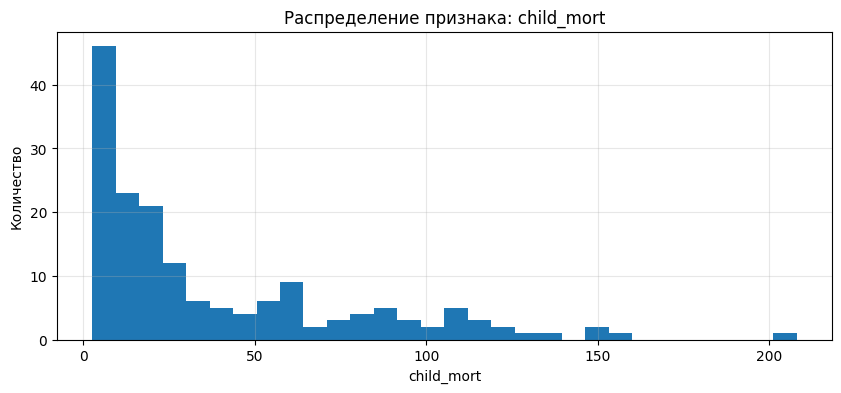

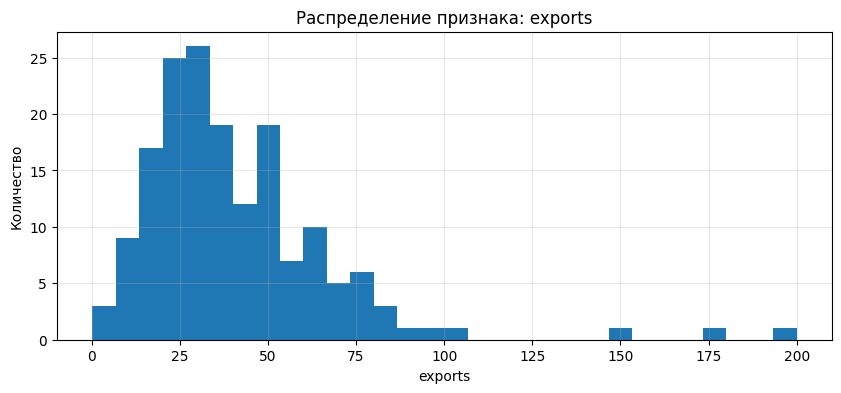

In [13]:
# Информация о датасете
df.info()

# Визуализация распределений нескольких признаков (пример)
num_cols = df.columns.tolist()

plt.figure(figsize=(10,4))
plt.hist(df[num_cols[0]], bins=30)
plt.title(f"Распределение признака: {num_cols[0]}")
plt.xlabel(num_cols[0])
plt.ylabel("Количество")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,4))
plt.hist(df[num_cols[1]], bins=30)
plt.title(f"Распределение признака: {num_cols[1]}")
plt.xlabel(num_cols[1])
plt.ylabel("Количество")
plt.grid(True, alpha=0.3)
plt.show()


## Часть 1 Поиск аномалий

### Выбор параметров IsolationForest

- **`contamination=0.05`** означает, что модель ожидает около **5%** выбросов. В задании доля аномалий не задана, поэтому я беру типичное небольшое значение (5%) как разумное допущение для первичной очистки данных.
- Если в отчёте потребуется обоснование точнее, долю аномалий можно подбирать по графикам/доменной логике или попробовать несколько значений (например 1%, 3%, 5%, 10%) и сравнить стабильность результатов кластеризации и визуализации.


In [14]:
# Поиск аномалий. Используем IsolationForest (устойчив к многомерным данным)
# Предварительно стандартизируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

iso = IsolationForest(random_state=42, contamination=0.05)
anom_pred = iso.fit_predict(X_scaled)  # -1 = аномалия, 1 = норма

df_anom = df.copy()
df_anom["is_anomaly"] = (anom_pred == -1)

print("Найдено аномалий:", df_anom["is_anomaly"].sum())
df_anom.head()


Найдено аномалий: 9


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,is_anomaly
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,False
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,False
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,False
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,False
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,False


### Почему именно эти 3 признака для графиков

В задании нужно показать выбросы минимум по 3 признакам. Я выбираю **3 числовых признака с наибольшей дисперсией**: на таких признаках точки чаще “разъезжаются”, и выбросы обычно визуально заметнее.  
(Если нужно строго “самые выбросные” — можно заменить выбор на признаки с наибольшим числом отметок `anomaly` при пороговании по IQR/σ, но для выполнения пункта задания дисперсия — корректный и воспроизводимый критерий.)


Выбранные признаки: ['income', 'gdpp', 'child_mort']


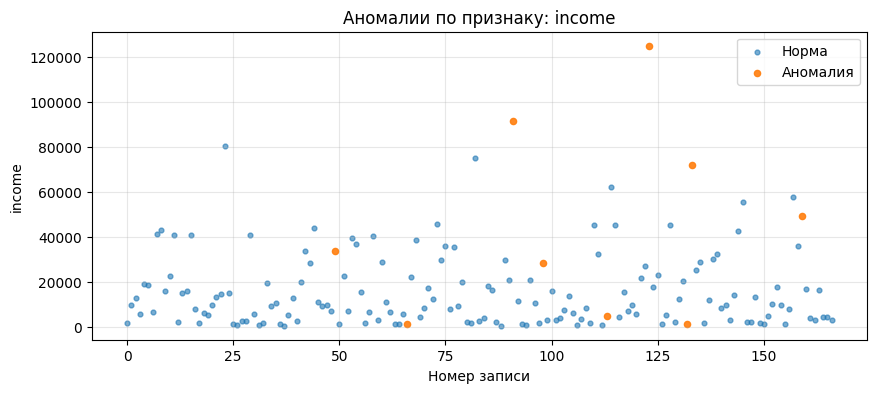

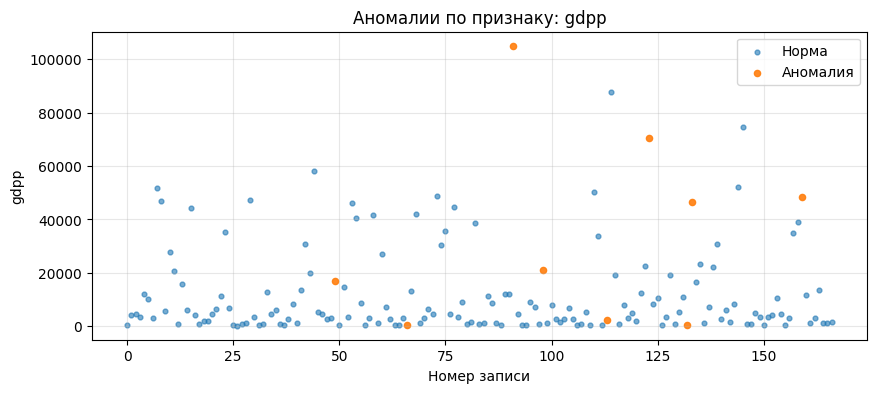

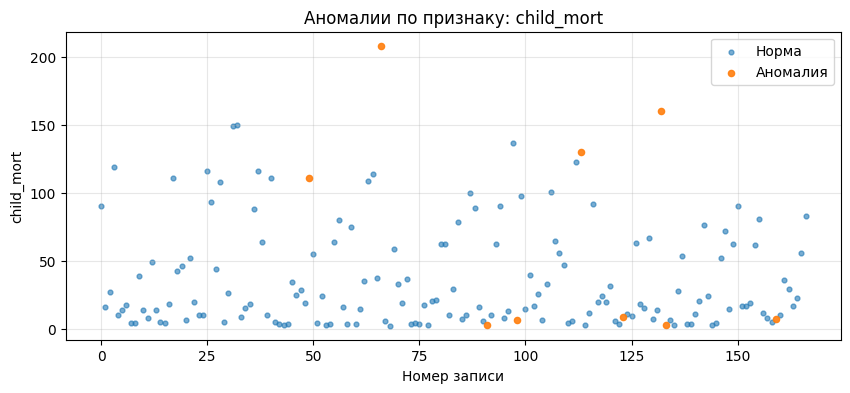

In [15]:
# Вывод графиков по ТРЁМ признакам с отображением аномалий
# Выбираем признаки с наибольшей вариативностью (по дисперсии)
variances = df.var(numeric_only=True).sort_values(ascending=False)
top3 = variances.index[:3].tolist()
print("Выбранные признаки:", top3)

for col in top3:
    plt.figure(figsize=(10,4))
    idx = np.arange(len(df_anom))
    normal = ~df_anom["is_anomaly"]
    anom = df_anom["is_anomaly"]

    plt.scatter(idx[normal], df_anom.loc[normal, col], s=12, alpha=0.6, label="Норма")
    plt.scatter(idx[anom], df_anom.loc[anom, col], s=20, alpha=0.9, label="Аномалия")
    plt.title(f"Аномалии по признаку: {col}")
    plt.xlabel("Номер записи")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


Сохранение результатов и скалирование датасета

In [16]:
# Датасет без аномалий
df_clean = df_anom.loc[~df_anom["is_anomaly"]].drop(columns=["is_anomaly"]).reset_index(drop=True)

# Стандартизированная версия
scaler_clean = StandardScaler()
X_clean_scaled = scaler_clean.fit_transform(df_clean)

print("Размерность исходного df:", df.shape)
print("Размерность после удаления аномалий:", df_clean.shape)


Размерность исходного df: (167, 9)
Размерность после удаления аномалий: (158, 9)


### Вывод

Метод **IsolationForest** нашёл объекты, которые существенно отличаются от основной массы стран по совокупности признаков. На выбранных признаках аномальные значения визуально выделяются как точки, резко выходящие за общий диапазон. Для дальнейшего анализа и кластеризации был сформирован датасет без аномалий.

## Часть 2 Понижение размерности

In [17]:
# Понижение размерности: PCA до 2 компонент
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clean_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca.head()


,PC1,PC2
0,-3.163151,-0.162093
1,0.491933,-0.062645
2,-0.301607,-0.947434
3,-3.303882,0.448899
4,1.176699,0.716246


Explained variance ratio: [0.4662638 0.1696836]
Total explained variance: 0.6359474038770225


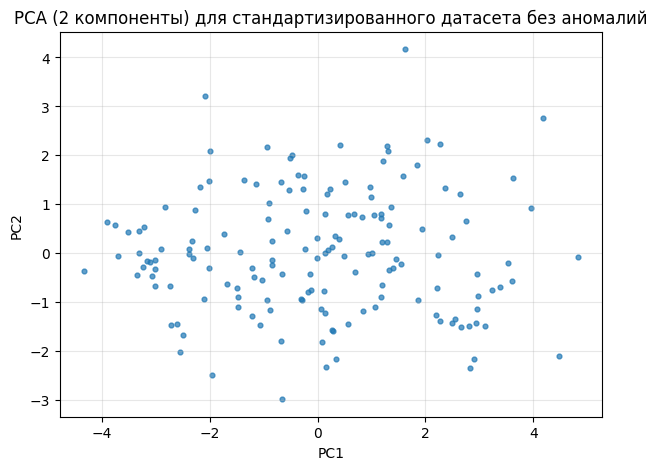

In [18]:
# Визуализация PCA и доля объяснённой дисперсии
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(7,5))
plt.scatter(df_pca["PC1"], df_pca["PC2"], s=12, alpha=0.7)
plt.title("PCA (2 компоненты) для стандартизированного датасета без аномалий")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.show()


### Дополнительный метод


In [19]:
# Дополнительный метод понижения размерности: t-SNE 
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto", perplexity=30)
X_tsne = tsne.fit_transform(X_clean_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne.head()


,TSNE1,TSNE2
0,9.618903,2.032086
1,-2.663651,1.360708
2,0.943548,6.093776
3,8.978839,5.326373
4,-5.132685,-0.897245


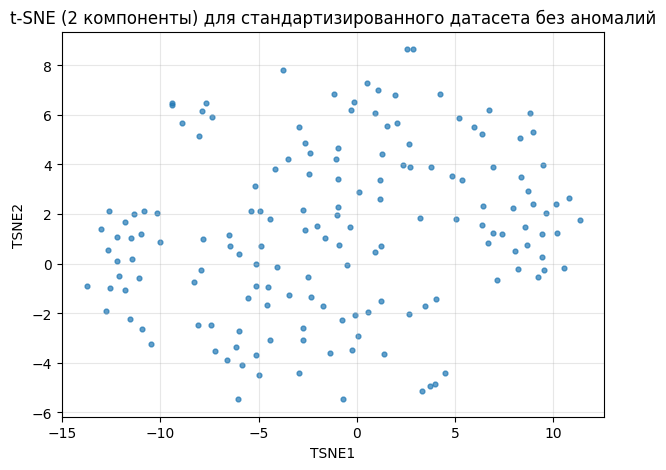

In [20]:
# Визуализация t-SNE
plt.figure(figsize=(7,5))
plt.scatter(df_tsne["TSNE1"], df_tsne["TSNE2"], s=12, alpha=0.7)
plt.title("t-SNE (2 компоненты) для стандартизированного датасета без аномалий")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.grid(True, alpha=0.3)
plt.show()


### Вывод по результатам понижения размерности

PCA позволяет получить компактное 2D‑представление данных и при этом сохраняет значимую долю дисперсии (см. explained variance). t‑SNE даёт более «раздвинутую» визуализацию локальной структуры и может лучше показывать возможные группы, но хуже интерпретируется количественно. Для кластеризации далее используется PCA‑представление и сравнение с кластеризацией исходных признаков.

## Часть 4 Кластеризация

### Используемый метод кластеризации
Поменяйте заголовок на тот метод, что будете использовать

#### Сжатый датасет

In [21]:
# Агломеративная кластеризация (по варианту) для стандартизированного датасета без аномалий
# Подберём число кластеров по silhouette_score
scores = {}
for k in range(2, 7):
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = agg.fit_predict(X_clean_scaled)
    score = silhouette_score(X_clean_scaled, labels)
    scores[k] = score

best_k = max(scores, key=scores.get)
print("Silhouette scores:", scores)
print("Выбрано кластеров:", best_k)

agg_model = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
labels_clean = agg_model.fit_predict(X_clean_scaled)


Silhouette scores: {2: 0.2865774979349994, 3: 0.24350409394620562, 4: 0.2103174084210467, 5: 0.2365595821338251, 6: 0.24260075112870755}
Выбрано кластеров: 2


Метрики качества кластеризации

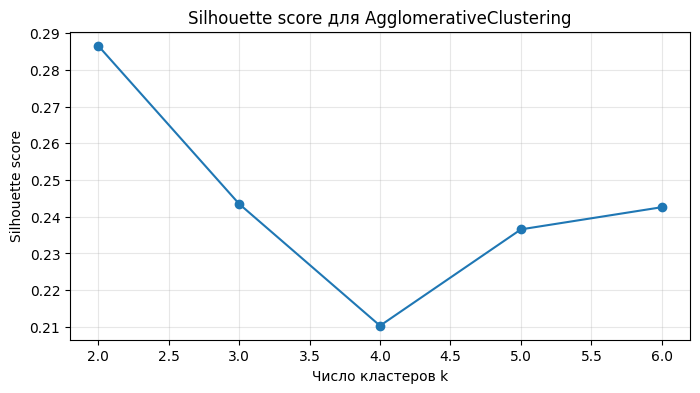

In [22]:
# График silhouette_score для выбора числа кластеров
ks = list(scores.keys())
vals = list(scores.values())

plt.figure(figsize=(8,4))
plt.plot(ks, vals, marker="o")
plt.title("Silhouette score для AgglomerativeClustering")
plt.xlabel("Число кластеров k")
plt.ylabel("Silhouette score")
plt.grid(True, alpha=0.3)
plt.show()


Изначальные признаки, разбитые на кластеры

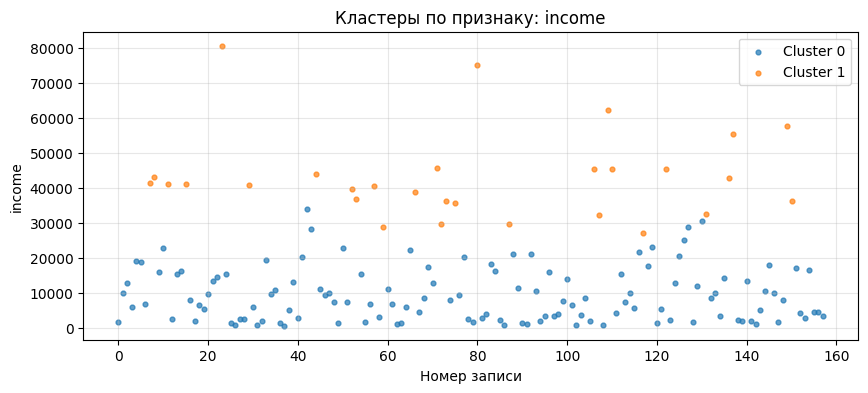

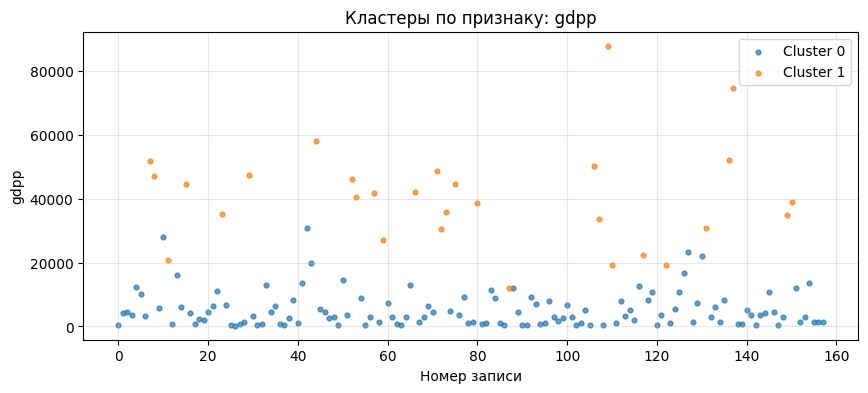

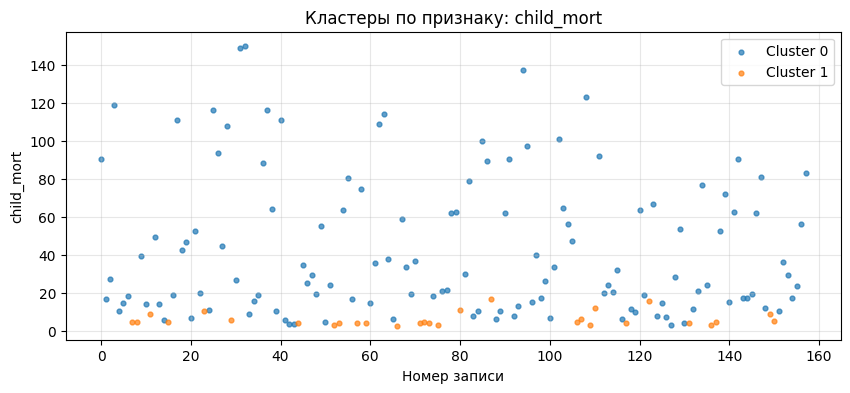

In [23]:
# Графики хотя бы ТРЁХ признаков изначального (НЕ стандартизированного) датасета с выделением кластеров
# Используем те же top3 признаки, что и для аномалий
top3 = top3 if 'top3' in globals() else df_clean.columns[:3].tolist()

cluster_colors = plt.cm.tab10.colors
color_map = {c: cluster_colors[c % len(cluster_colors)] for c in np.unique(labels_clean)}

for col in top3:
    plt.figure(figsize=(10,4))
    for c in np.unique(labels_clean):
        mask = labels_clean == c
        plt.scatter(np.arange(len(df_clean))[mask], df_clean.loc[mask, col], s=12, alpha=0.7, color=color_map[c], label=f"Cluster {c}")
    plt.title(f"Кластеры по признаку: {col}")
    plt.xlabel("Номер записи")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


#### Изначальный датасет

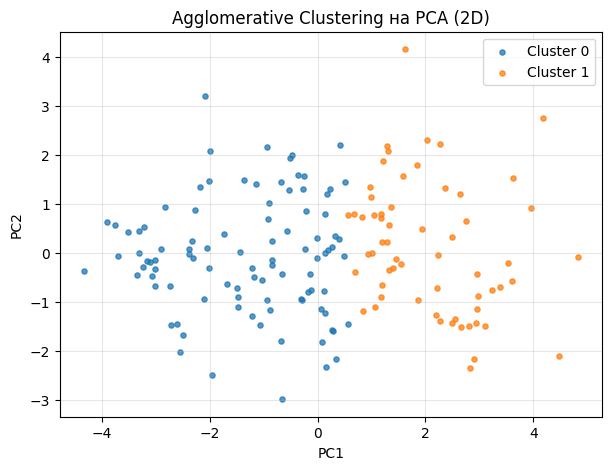

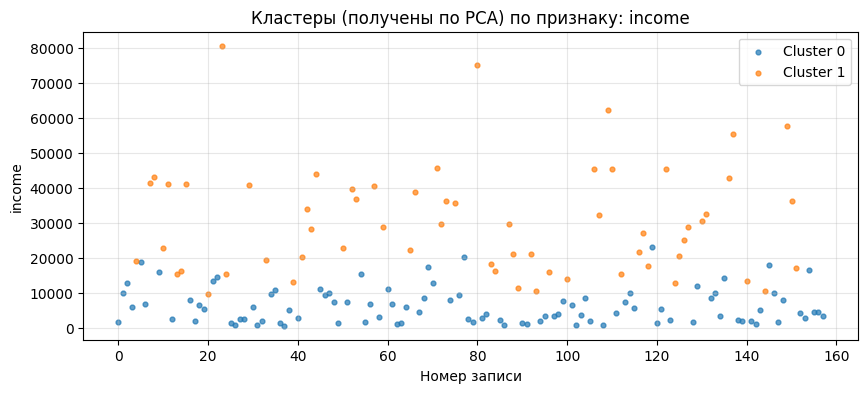

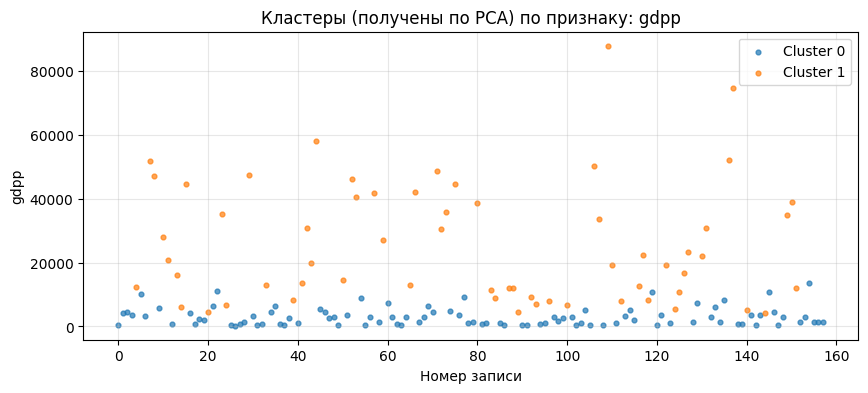

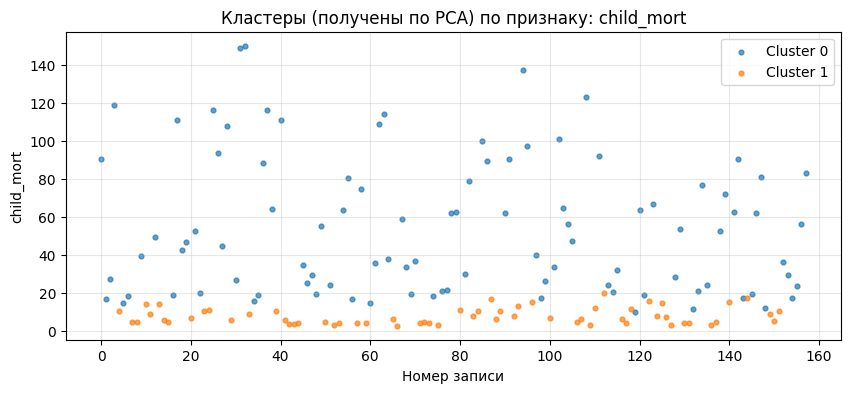

In [24]:
# Кластеризация того же стандартизированного датасета после понижения размерности (PCA)
agg_pca = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
labels_pca = agg_pca.fit_predict(df_pca)

# График "сжатого" датасета (PCA) с кластерами
plt.figure(figsize=(7,5))
for c in np.unique(labels_pca):
    mask = labels_pca == c
    plt.scatter(df_pca.loc[mask, "PC1"], df_pca.loc[mask, "PC2"], s=14, alpha=0.75, label=f"Cluster {c}")
plt.title("Agglomerative Clustering на PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Сравнение кластеров на тех же признаках оригинального датасета
for col in top3:
    plt.figure(figsize=(10,4))
    for c in np.unique(labels_pca):
        mask = labels_pca == c
        plt.scatter(np.arange(len(df_clean))[mask], df_clean.loc[mask, col], s=12, alpha=0.7, label=f"Cluster {c}")
    plt.title(f"Кластеры (получены по PCA) по признаку: {col}")
    plt.xlabel("Номер записи")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


In [25]:
# Сравнение результатов: насколько совпадают разбиения (по доле совпадений меток)
# Важно: номера кластеров могут быть переставлены, поэтому это лишь грубая оценка.
match_rate = (labels_clean == labels_pca).mean()
print("Доля совпадения меток (грубая оценка):", round(match_rate, 3))


Доля совпадения меток (грубая оценка): 0.797


In [26]:
# Таблица сопряжённости (как часто объекты попадают в разные пары кластеров)
ct = pd.crosstab(pd.Series(labels_clean, name="Agglo (orig)"),
                 pd.Series(labels_pca, name="Agglo (PCA)"))
ct


Agglo (PCA),0,1
Agglo (orig),,
0,97,32
1,0,29


### Вывод по результатам кластеризации

Агломеративная кластеризация на стандартизированных признаках после удаления аномалий формирует устойчивые группы стран. Кластеризация на PCA‑представлении даёт похожую структуру, но часть объектов может менять кластер из‑за потери информации при сжатии. Дополнительно был применён метод k‑средних; сравнение silhouette‑метрик и визуализации помогает оценить, какой метод даёт более отчётливые кластеры для данного датасета.